<a href="https://colab.research.google.com/github/muddasirmd/Automatic-Image-Captioning/blob/main/Automatic_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

**Set up Directories**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
# example1 = "./gdrive/MyDrive/Colab Notebooks/Flicker8k Dataset/captions.txt"
# file1 = open(example1, "r")
# FileContent = file1.read()
# FileContent

In [ ]:
BASE_DIR = './gdrive/MyDrive/Colab Notebooks/Flicker8k Dataset'
WORKING_DIR = './gdrive/MyDrive/Colab Notebooks/Flicker8k Dataset/'

Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model by removing last layer (output layer)
model = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
# print model summary
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# # Extract Features from Images
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):

#   # only run for the first time

#   # load the image from file
#   img_path = directory + '/' + img_name
#   image = load_img(img_path, target_size=(224,224))

#   # Convert image pixels to numpy array
#   image = img_to_array(image)

#   # reshape data for model
#   image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

#   # preprocess image for vgg (this will scale down image)
#   image = preprocess_input(image)

#   # Extract features
#   feature = model.predict(image, verbose=0)

#   # Get image id
#   img_id = img_name.split('.')[0]

#   # Store features
#   features[img_id] = feature


In [ ]:
# Store features in a pickle file
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# Load features from file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

**Load the Captions Data**

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}

# Process lines
for line in tqdm(captions_doc.split('\n')):

  # Split the line by comma
  tokens = line.split(',')
  if len(tokens) < 2:
    continue
  img_id, caption = tokens[0], tokens[1:]

  # Remove extension from Image Id
  img_id = img_id.split('.')[0]

  # Convert caption list to string
  caption = " ".join(caption)

  # create list if needed
  if img_id not in mapping:
    mapping[img_id] = []
    
  mapping[img_id].append(caption)
  

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
mapping['166433861_70b66cd381']

['A motorcycle racer leans his bike .',
 'A motorcyclist is driving down a road on their motorbike .',
 'A motorcyclist is riding their sponsored car along a roadway that has recently turned .',
 'A motorcyclist on the street .',
 'A motorcyclist with a red helmet rides his blue motorcycle down the road .']

**Preprocess Text Data (Captions)**

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    # Take one caption at a time
    for i in range(len(captions)):
      caption = captions[i]
      # Preprocessing Steps
      # Convert to lowercase
      caption = caption.lower()
      # Remove digits, special characters, etc. only keep the letters
      caption = caption.replace('[^A-Za-z]','')
      # Remove additional spaces
      caption = caption.replace('\s+', ' ')
      # Remove articles and single length letters
      caption = " ".join([word for word in caption.split() if len(word) > 1 ])
      # add <start> and <end> tags to the caption. (Needed in Seq to Seq models)
      # caption = "<start> " + caption + " <end>" # this one caused problems in training because of special characters
      caption = "startseq " + caption + " endseq"
      captions[i] = caption

In [ ]:
# Before Preprocess
mapping['166433861_70b66cd381']

['A motorcycle racer leans his bike .',
 'A motorcyclist is driving down a road on their motorbike .',
 'A motorcyclist is riding their sponsored car along a roadway that has recently turned .',
 'A motorcyclist on the street .',
 'A motorcyclist with a red helmet rides his blue motorcycle down the road .']

In [ ]:
# Preprocess Caption Data
clean(mapping)

In [ ]:
# After Preprocess
mapping['166433861_70b66cd381']

['startseq motorcycle racer leans his bike endseq',
 'startseq motorcyclist is driving down road on their motorbike endseq',
 'startseq motorcyclist is riding their sponsored car along roadway that has recently turned endseq',
 'startseq motorcyclist on the street endseq',
 'startseq motorcyclist with red helmet rides his blue motorcycle down the road endseq']

Create Vocabulary

In [ ]:
# Get all captions in one list
all_captions = []

for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# Tokenize the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# Get maximum length of caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Train Test Split**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Data Generator**

In [ ]:
sequences = tokenizer.texts_to_sequences(["startseq Mo Salah running down the wing endseq"])[0]
sequences

[1, 31, 36, 4, 2]

Add a Data Generator to get data in batchs (to avoid session crash because of low memory)
(if more than 16gb than no need of this function)

In [ ]:
# Preparing training data
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0

  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0] # get list of corresponding word indexs from vocabulary
        # split the sequence in X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          input_seq, output_seq = seq[:i], seq[i]
          # pad input sequence
          input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
          # encode output sequence (one-hot encoding)
          output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0]) # image features
          X2.append(input_seq)
          y.append(output_seq)
      
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y

        X1, X2, y = list(), list(), list()
        n = 0


**Model Creation**

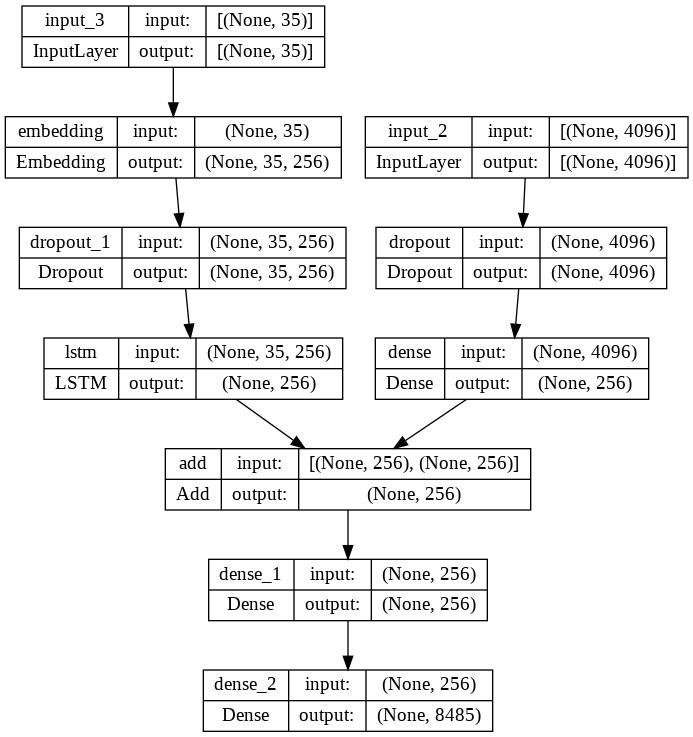

In [ ]:
# Encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# first load model weights (if there any)
model.load_weights(WORKING_DIR+'/model_after_180_epochs.h5')

Train Model

In [ ]:
epochs = 10
batch_size = 64
steps = len(train) // batch_size # error backpropagation after this num

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for 1 epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 42s 368ms/step - loss: 1.2242 - accuracy: 0.6387


In [ ]:
# save the model (180 epochs)
model.save(WORKING_DIR+'/model_after_180_epochs.h5')

In [ ]:
# load the model
# model.load_weights(WORKING_DIR+'/best_model.h5')

Generate Captions of the Images

In [ ]:
# function for converting indexs to words
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
# for predicting caption
def predict_caption(model, image, tokenizer, max_length):
  # add <start> tag for generation process
  input_text = "startseq"
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([input_text])[0]
    # pad sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    input_text += " " + word
    # stop if reach the end tag
    if word == 'endseq':
      break
  
  return input_text

In [ ]:
from threading import active_count
# Validate with Test Data
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(),list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate the BLEU Score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.516853
BLEU-2: 0.291378


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  # load the image
  image_id = image_name.split(".")[0]
  image_path = os.path.join(BASE_DIR, 'Images', image_name)
  image = Image.open(image_path)
  captions = mapping[image_id]
  print("------------------Actual------------------")
  for caption in captions:
    print(caption)
  # predict the caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  # remove startseq and endseq from the caption
  y_pred = y_pred[9:-7]
  print("----------------Predicted-----------------")
  print(y_pred)
  plt.imshow(image)

In [ ]:
train[:2]

['1000268201_693b08cb0e', '1001773457_577c3a7d70']

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

------------------Actual------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
----------------Predicted-----------------
little girl in dress and tie is sitting on wooden bench


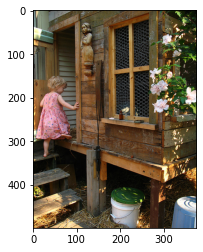

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")

------------------Actual------------------
startseq boy pitches in baseball game endseq
startseq boy winding up for pitch endseq
startseq young baseball player winds up to throw the ball endseq
startseq young person pitches in baseball game endseq
startseq the baseball player is throwing the ball endseq
----------------Predicted-----------------
baseball player winds up to throw the ball


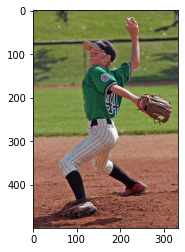

In [ ]:
generate_caption("3744832122_2f4febdff6.jpg")

------------------Actual------------------
startseq bike in field and two kites endseq
startseq kid is riding bike in an open field endseq
startseq landscape picture of motorcyclist and person flying kites endseq
startseq kites attached to wheeled devices in field endseq
startseq two people fly kites in field endseq
----------------Predicted-----------------
landscape picture of motorcyclist and person flying kites


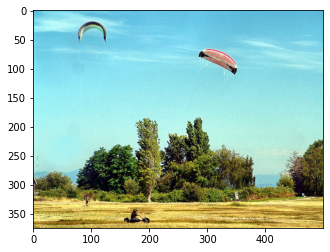

In [ ]:
generate_caption("3726019124_f302b3d48a.jpg")

------------------Actual------------------
startseq group of mountain bikers race each other down dirt hill endseq
startseq group of people do tricks on motorbikes endseq
startseq dirt bikers riding off jump endseq
startseq four motorcycle racers are on dirt track endseq
startseq four motorcycles are racing on dirt track endseq
----------------Predicted-----------------
group of mountain bikers race down dirt hill


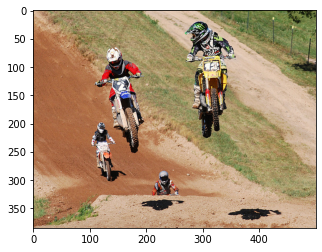

In [ ]:
generate_caption("3717309680_e5105afa6d.jpg")

**Test Data**

In [ ]:
test[1]

'436393371_822ee70952'

------------------Actual------------------
startseq man prepares to enter the red building endseq
startseq man walking around the corner of red building endseq
startseq man walks past red building with fake rocket attached to it endseq
startseq man walks under building with large rocket shaped sculpture endseq
startseq person walking by red building with jet on top of it endseq
----------------Predicted-----------------
man stands on surfboard just above the long grass of some red house


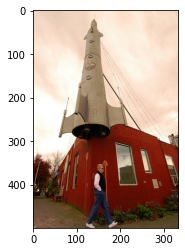

In [ ]:
generate_caption("436015762_8d0bae90c3.jpg")

------------------Actual------------------
startseq clown shares cut-out pictures of children endseq
startseq dirty looking clown holding up two paper cut outs of children with blond hair endseq
startseq man wearing balloon hat and grassy shirt holds up two large paper dolls endseq
startseq man wearing balloon hat holds up colored cut-out drawings of two men endseq
startseq the man wears balloons on his head and holds paper people endseq
----------------Predicted-----------------
the girl in the red top is standing next to tall girl in pink


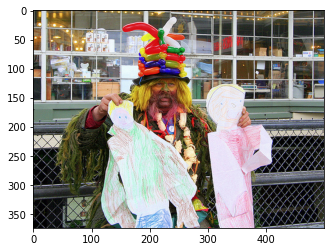

In [ ]:
generate_caption("440184957_267f3f3a2b.jpg")

In [ ]:
test[13]

'440184957_267f3f3a2b'